# Testing Zero-Inflated Count Matrix Factorization in Zeisel data 

In [1]:
from pCMF.misc import utils, plot_utils
from pCMF.models.pcmf.inferences import cavi_new, svi_new

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd
from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
data_path = '../../data/Zeisel/expression_mRNA_17-Aug-2014.txt'

In [3]:
X = pd.read_csv(data_path, sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
precise_clusters = np.array(X[0], dtype=str)[2:]
celltypes, labels = np.unique(clusters, return_inverse=True)
_, precise_labels = np.unique(precise_clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression = np.array(X, dtype=np.int)[1:]

In [4]:
for i in np.unique(labels):
    print('{}: {} ({})'.format(i, clusters[np.where(labels == i)[0][0]], len(np.where(labels == i)[0])))

0: astrocytes_ependymal (224)
1: endothelial-mural (235)
2: interneurons (290)
3: microglia (98)
4: oligodendrocytes (820)
5: pyramidal CA1 (939)
6: pyramidal SS (399)


In [5]:
# keep the most variable genes according to the biscuit paper
selected = np.std(expression, axis=0).argsort()[-558:][::-1]
expression = expression[:, selected]
gene_names = gene_names[selected].astype(str)

In [6]:
sortedex = np.sort(expression.flatten())[:int(0.95*expression.size)]

In [7]:
np.unique(sortedex)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [8]:
bins = np.linspace(0, sortedex.max(), num=50)

plt.hist(sortedex, bins)
plt.xlabel('observed counts')
plt.ylabel('frequency')
plt.show()

In [9]:
#train/test split
X_train, X_test, clusters_train, clusters_test, c_train, c_test, cp_train, cp_test = train_test_split(expression, clusters, labels, precise_labels)

In [10]:
for i in np.unique(c_train):
    print('{}: {} ({})'.format(i, clusters_train[np.where(c_train == i)[0][0]], len(np.where(c_train == i)[0])))

0: astrocytes_ependymal (171)
1: endothelial-mural (165)
2: interneurons (213)
3: microglia (82)
4: oligodendrocytes (617)
5: pyramidal CA1 (710)
6: pyramidal SS (295)


In [11]:
T = 60. * 30.
S = 30.
max_iter = 1

In [12]:
P = expression.shape[1]
K = 1 # latent space dimensionality
C = np.unique(c_train).size

In [12]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(X_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [14]:
# Prior parameters
alpha = np.abs(np.ones((2, K)) + np.random.rand(2, K))
beta = np.abs(np.ones((2, P, K)) + np.random.rand(2, P, K))
logit_pi_D = np.random.rand(P)
pi_D = np.exp(logit_pi_D) / (1. + np.exp(logit_pi_D))

In [17]:
print('Stochastic Zero-Inflated GaP-EB:')
infzigapeb = svi_new.StochasticVI(X_train, alpha, beta, pi_D=pi_D, minibatch_size=1, empirical_bayes=True)
infzigapeb.run(n_iterations=100, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
zigapeb_U = infzigapeb.a[0] / infzigapeb.a[1] # VI estimate is the mean of the variational approximation
zigapeb_V = infzigapeb.b[0] / infzigapeb.b[1]
zigapeb_D = infzigapeb.estimate_D(infzigapeb.p_D)
zigapeb_S = infzigapeb.estimate_S(infzigapeb.p_S)
#zigapeb_tsne = TSNE(n_components=2).fit_transform(zigapeb_U)

Stochastic Zero-Inflated GaP-EB:
Iteration 99/100. Log-likelihood: 2.102. Elapsed: 0h0m22s


NameError: name 'infgapeb' is not defined

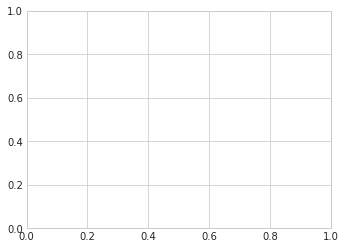

In [15]:
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(infgapeb.ll_time, label='GaP-EB')
ax.plot(infzigapeb.ll_time, label='ZIGaP-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds(*{0})'.format(S))

ax = plt.subplot(1, 2, 2)
ax.plot(infgapeb.silh_time, label='GaP-EB')
ax.plot(infzigapeb.silh_time, label='ZIGaP-EB')
plt.ylabel('Silhouette of latent space')
plt.xlabel('Seconds(*{0})'.format(S))

plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Zeisel data', fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()

In [45]:
# Experiment parameters
T = 60. * 30.
S = 30.
max_iter = 1
K = 1 # latent space dimensionality
mb_size = 1

In [46]:
param_dict = {'T': T, 'S' : S, 'max_iter': max_iter, 'K': K, 'mb_size' : mb_size}

In [50]:
print('Experiment parameters:')
for param in param_dict:
    print('{0}: {1}'.format(param, param_dict[param]))

Experiment parameters:
T: 1800.0
S: 30.0
max_iter: 1
K: 1
mb_size: 1


In [ ]:
gapeb_dll = utils.log_likelihood(X_train, gapeb_U, gapeb_V, infgapeb.p_D, gapeb_S)
zigapeb_dll = utils.log_likelihood(X_train, zigapeb_U, zigapeb_V, infzigapeb.p_D, zigapeb_S)

scores = {'GaP-EB': gapeb_dll, 'ZIGaP-EB': zigapeb_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

In [ ]:
gapeb_holl = infgapeb.predictive_ll(X_test)
zigapeb_holl = infzigapeb.predictive_ll(X_test)

scores = {'GaP-EB': gapeb_holl, 'ZIGaP-EB': zigapeb_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

In [43]:
#gapeb_silh = silhouette_score(gapeb_U, c_train)
zigapeb_silh = silhouette_score(zigapeb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'ZIGaP-EB': zigapeb_silh, 'PCA1': pca_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Silhouette scores (higher is better):
- PCA1: -0.0668
- PCA: -0.0668
- ZIGaP-EB: -0.229


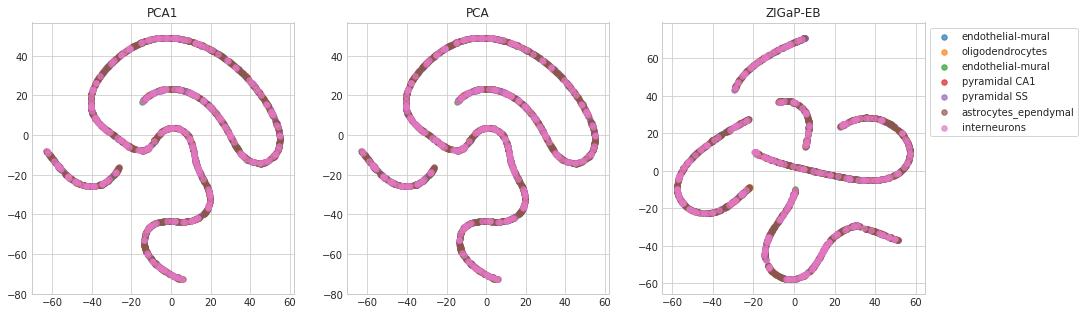

In [44]:
# Plot in decreasing silhouette order
U_list = [zigapeb_tsne,pca_tsne, pca_tsne]
title_list = ['ZIGaP-EB', 'PCA1',  'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 5))

s = 30
alpha = 0.7
# labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], 
                       s=s, alpha=alpha, label=clusters_train[c])
        handlers.append(h)
    plt.title(sorted_scores[i][0])

if labels is not None:
    ax.legend(bbox_to_anchor=[1., 1.], frameon=True)
plt.show()